In [1]:
import os
import tempfile

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import torch
from torch.utils.data import DataLoader, random_split, TensorDataset
from sklearn.preprocessing import OneHotEncoder
import lightning.pytorch as L
from model import CVAE
from datetime import datetime
from os.path import join
import pytz

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
adata_raw = sc.datasets.pbmc3k()
adata_raw

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [4]:
adata_processed = sc.datasets.pbmc3k_processed()
adata_processed

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [5]:
adata_processed.obs["louvain"]

index
AAACATACAACCAC-1        CD4 T cells
AAACATTGAGCTAC-1            B cells
AAACATTGATCAGC-1        CD4 T cells
AAACCGTGCTTCCG-1    CD14+ Monocytes
AAACCGTGTATGCG-1           NK cells
                         ...       
TTTCGAACTCTCAT-1    CD14+ Monocytes
TTTCTACTGAGGCA-1            B cells
TTTCTACTTCCTCG-1            B cells
TTTGCATGAGAGGC-1            B cells
TTTGCATGCCTCAC-1        CD4 T cells
Name: louvain, Length: 2638, dtype: category
Categories (8, object): ['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'CD8 T cells', 'NK cells', 'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes']

In [6]:
adata = adata_raw[adata_processed.obs_names].copy()
adata.obs["ct"] = adata_processed.obs["louvain"].values
adata.obsm["X_umap"] = adata_processed.obsm["X_umap"].copy()
adata

AnnData object with n_obs × n_vars = 2638 × 32738
    obs: 'ct'
    var: 'gene_ids'
    obsm: 'X_umap'

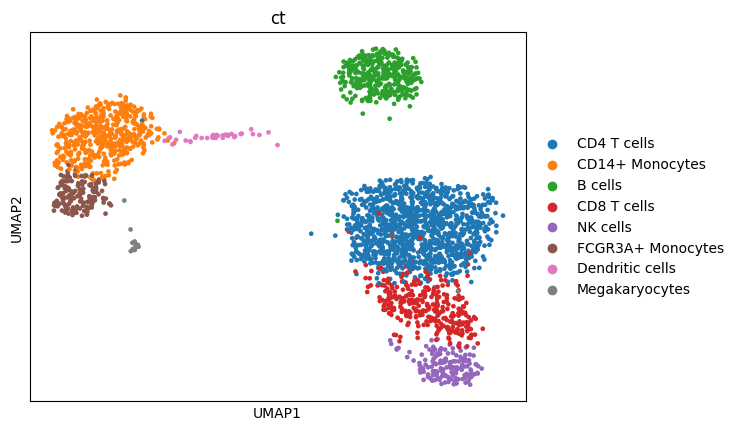

In [7]:
sc.pl.umap(adata, color="ct")

In [8]:
X = adata.X.toarray()

ct = np.asarray(list(adata.obs["ct"].values)).reshape(-1, 1)
y_one_hot_encoder = OneHotEncoder()
y_one_hot_encoder.fit(ct)
y = y_one_hot_encoder.transform(ct).toarray()

all_data = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))

In [9]:
train_len = int(0.8*len(all_data))
val_len = len(all_data) - train_len

train_data, val_data = random_split(all_data, [train_len, val_len])

In [10]:
torch.cuda.is_available()

True

In [11]:
library_mean = np.mean(np.log(np.sum(X,axis=-1)))
library_mean

7.689542

In [12]:
library_logvar = np.log(np.var(np.log(np.sum(X,axis=-1))))
library_logvar

-1.7721794

In [13]:
y_one_hot_encoder.categories_

[array(['B cells', 'CD14+ Monocytes', 'CD4 T cells', 'CD8 T cells',
        'Dendritic cells', 'FCGR3A+ Monocytes', 'Megakaryocytes',
        'NK cells'], dtype='<U17')]

In [14]:
y_prior = np.asarray([sum(ct.squeeze()==y_)/len(ct) for y_ in y_one_hot_encoder.categories_[0]])
y_prior

array([0.12964367, 0.18195603, 0.43366187, 0.11978772, 0.01402578,
       0.05686126, 0.00568613, 0.05837756])

In [15]:
model = CVAE(x_dim=X.shape[-1],
             y_dim=y.shape[-1],
             hidden_dim_list=[10],
             z1_dim=10,
             z2_dim=10,
             library_mean=library_mean,
             library_logvar=library_logvar,
             y_prior=y_prior,
            )

In [16]:
run_name = datetime.now(pytz.timezone('America/Los_Angeles')).strftime("%Y-%m-%d_%H-%M-%S")
ckpt_callback = L.callbacks.ModelCheckpoint(join("ckpt", run_name), monitor="valid total loss", mode="min")
patience_callback = L.callbacks.EarlyStopping(monitor="valid total loss", patience=20)
progress_bar_callback = L.callbacks.TQDMProgressBar(refresh_rate=100)
logger = L.loggers.TensorBoardLogger("tb_log", name="cvae")

trainer = L.Trainer(max_epochs=500,
                    accelerator="cuda",
                    callbacks=[ckpt_callback, patience_callback,progress_bar_callback],
                    logger=logger)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=32, num_workers=2) 
valid_dataloader = DataLoader(val_data, shuffle=False, batch_size=32, num_workers=2) 

In [18]:
trainer.fit(model, train_dataloader, valid_dataloader)

You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params
-------------------------------------------
0 | x_to_z1_l  | x_to_z1_l   | 655 K 
1 | z1_l_to_x  | z1_l_to_x   | 753 K 
2 | z1_to_y    | MLP         | 198   
3 | z1_y_to_z2 | GaussianMLP | 410   
4 | z2_y_to_z1 | GaussianMLP | 410   
-------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.637     Total estimated model params size (MB)


Sanity Checking: |                                      | 0/? [00:00<?, ?it/s]

/home/ubuntu/miniconda3/envs/scvi/lib/python3.11/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/home/ubuntu/code/jupyter_notebooks/experimental/users/haoyang/scanvi_reimplement/model.py:97: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred_prob = F.softmax(y_pred_logit)


Training: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

In [19]:
best_model = CVAE.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
best_model.eval()

/home/ubuntu/miniconda3/envs/scvi/lib/python3.11/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


CVAE(
  (x_to_z1_l): x_to_z1_l(
    (x_to_z1): MLP(
      (network): Sequential(
        (0): Linear(in_features=32738, out_features=10, bias=True)
        (1): ReLU()
        (2): Linear(in_features=10, out_features=20, bias=True)
      )
    )
    (x_to_l): MLP(
      (network): Sequential(
        (0): Linear(in_features=32738, out_features=10, bias=True)
        (1): ReLU()
        (2): Linear(in_features=10, out_features=2, bias=True)
      )
    )
  )
  (z1_l_to_x): z1_l_to_x(
    (z1_to_scale): Sequential(
      (0): MLP(
        (network): Sequential(
          (0): Linear(in_features=10, out_features=10, bias=True)
          (1): ReLU()
          (2): Linear(in_features=10, out_features=32738, bias=True)
        )
      )
      (1): Softmax(dim=None)
    )
    (z1_to_h): MLP(
      (network): Sequential(
        (0): Linear(in_features=10, out_features=10, bias=True)
        (1): ReLU()
        (2): Linear(in_features=10, out_features=32738, bias=True)
      )
    )
  )
  (z1_

In [20]:
all_pred = model(torch.Tensor(X).to(model.device))
all_pred

{'l_sample': tensor([[22002.8672],
         [22026.4648],
         [22026.4648],
         ...,
         [15289.1562],
         [ 3697.4856],
         [16275.1602]], grad_fn=<ExpBackward0>),
 'l_mu': tensor([[10.0781],
         [14.5751],
         [10.0955],
         ...,
         [ 9.6375],
         [ 8.2312],
         [ 9.7023]], grad_fn=<SplitBackward0>),
 'l_logvar': tensor([[-6.9078],
         [-6.9078],
         [-6.9078],
         ...,
         [-6.9078],
         [-6.9078],
         [-6.9078]], grad_fn=<ClampBackward1>),
 'z1_sample': tensor([[ 0.2828, -1.2080, -0.4648,  ...,  1.1951, -0.2983,  0.1376],
         [ 2.3916,  3.1418, -3.0536,  ...,  0.9263,  2.4294,  1.6635],
         [ 0.3356, -2.8377, -1.3326,  ...,  2.1922,  0.3434, -0.3106],
         ...,
         [ 0.6501,  8.1087,  0.6433,  ...,  1.1575, -0.8834,  0.4148],
         [-1.1475,  4.3434,  0.9600,  ..., -0.8847, -1.4251,  0.4897],
         [ 0.3207,  1.4175, -0.0993,  ...,  2.4594, -0.5421, -0.0841]],
        grad

In [21]:
all_pred_y_prob = all_pred["y_pred_prob"].cpu().detach().numpy()
all_pred_y_prob[:10]

array([[3.53073445e-03, 4.51182532e-05, 9.95768905e-01, 3.28699316e-05,
        6.21657353e-04, 1.40140600e-07, 5.56033001e-07, 2.81913300e-13],
       [9.01563287e-01, 2.74248398e-03, 9.56441313e-02, 1.58129769e-22,
        5.02259900e-05, 1.65399039e-14, 8.36982496e-19, 4.96844384e-41],
       [1.18173454e-02, 1.65812326e-05, 9.86349881e-01, 2.09011359e-05,
        1.79524033e-03, 3.72582569e-08, 4.40321983e-08, 3.34894222e-16],
       [1.01814486e-08, 9.99830246e-01, 8.03424601e-12, 1.48084639e-16,
        1.23509278e-06, 1.68478306e-04, 7.04362124e-10, 1.43812628e-10],
       [1.57501690e-05, 2.82063047e-06, 1.59858901e-03, 9.71879542e-01,
        6.53517418e-06, 1.60555755e-05, 1.50040276e-02, 1.14766909e-02],
       [2.75026887e-05, 2.52263455e-08, 4.10201773e-03, 9.95808482e-01,
        2.95533900e-05, 4.48219062e-08, 1.93765409e-05, 1.29653090e-05],
       [4.87321195e-05, 7.81889611e-08, 5.62459929e-03, 9.94209290e-01,
        5.85594098e-05, 1.25039776e-07, 3.57091230e-05, 2.

In [22]:
all_pred_y_cat = [np.argmax(x) for x in all_pred_y_prob]
all_pred_y_cat[:10]

[2, 0, 2, 1, 3, 3, 3, 3, 2, 5]

In [23]:
all_pred_y_one_hot = np.zeros(all_pred_y_prob.shape)
for i in range(len(all_pred_y_one_hot)):
    all_pred_y_one_hot[i, all_pred_y_cat[i]] = 1
all_pred_y_one_hot

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

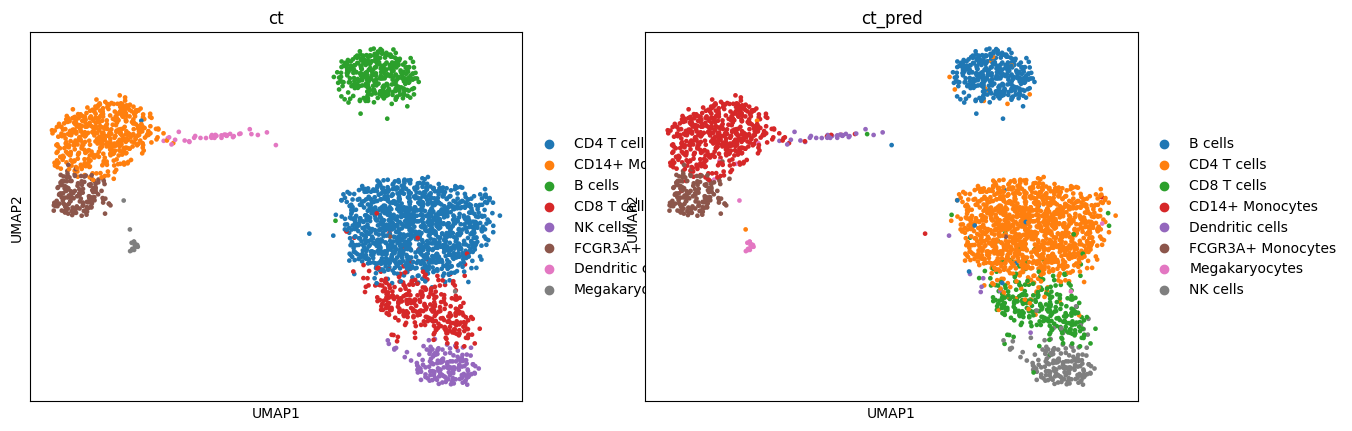

In [24]:
adata.obs["ct_pred"] = y_one_hot_encoder.inverse_transform(all_pred_y_one_hot)
sc.pl.umap(adata, color=["ct", "ct_pred"])

In [25]:
# z2 = all_pred["z2_mu"].cpu().detach().numpy()
# from sklearn.decomposition import PCA
# z2_pca = PCA(n_components=2).fit_transform(z2)
# adata.obsm["cvae_z2"] = z2_pca
# sc.pl.embedding(basis="cvae_z2", adata=adata, color=["ct", "ct_pred"], )

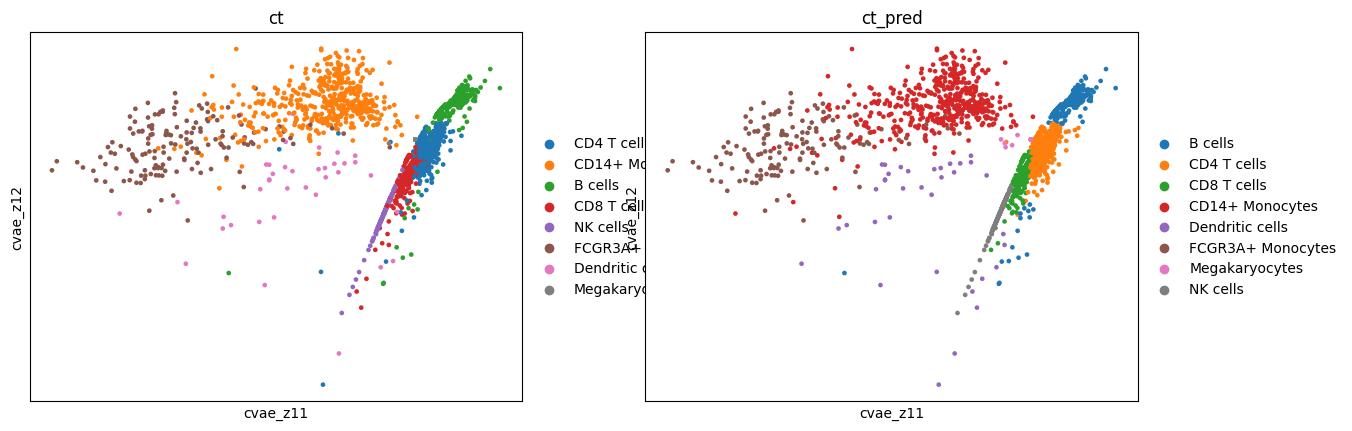

In [26]:
z1 = all_pred["z1_mu"].cpu().detach().numpy()
from sklearn.decomposition import PCA
z1_pca = PCA(n_components=2).fit_transform(z1)
adata.obsm["cvae_z1"] = z1_pca
sc.pl.embedding(basis="cvae_z1", adata=adata, color=["ct", "ct_pred"], )